In [1]:
# import everything needed
import ROOT
import time
import numpy as np
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import hist
import uproot
import matplotlib.pyplot as plt
import mplhep as hep

# configure ROOT's behavior
ROOT.gROOT.SetBatch()
ROOT.gStyle.SetOptStat("nemruoi")
ROOT.gROOT.ForceStyle()

Welcome to JupyROOT 6.26/07


/cvmfs/cms.cern.ch/el9_amd64_gcc11/external/py3-numpy/1.22.4-1e1240160543ee39175a125e9a5e9cae/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc11/external/py3-numpy/1.22.4-1e1240160543ee39175a125e9a5e9cae/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el9_amd64_gcc11/external/py3-numpy/1.22.4-1e1240160543ee39175a125e9a5e9cae/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc11/external/py3-numpy/1.22.4-1e1240160543ee39175a125e9a5e9cae/lib/python3.9/site-pac

--- 4.104645252227783 seconds ---


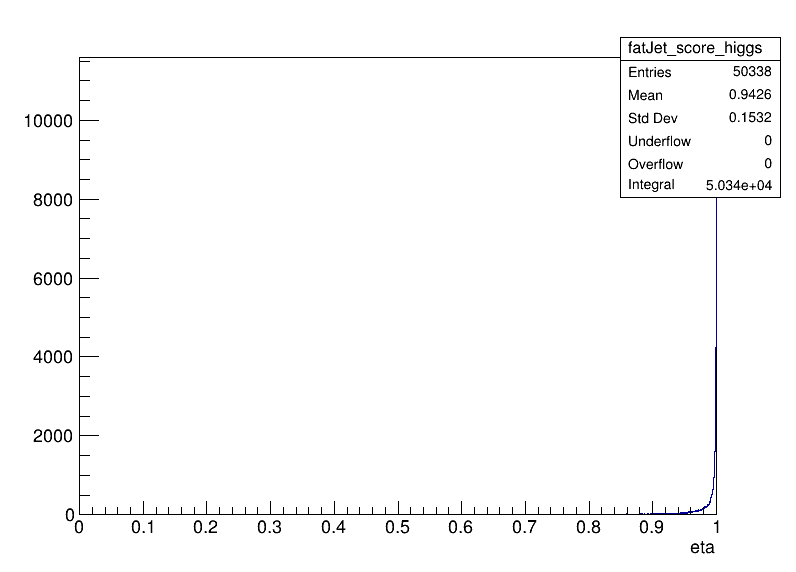

In [2]:
nBins = 2000
score_min = 0.
score_max = 1.
mass_cut = [100.,150.]
min_jet_mass = 60.
max_jet_mass = 250.
ptcut = 250.
etacut = 2.5


def HbbvsQCD(fatjet):
    score = (fatjet.particleNetMD_Xbb/(fatjet.particleNetMD_Xbb+fatjet.particleNetMD_QCD))
    return score

def FatJetMass(fatjet):
    return fatjet.msoftdrop


# this is a jet mask
def precut(fatjets):
    return (fatjets.pt>ptcut) & (np.absolute(fatjets.eta)<etacut)

#this is a jet mask
def higgs_cut(fatjets):
    return ( FatJetMass(fatjets) >= mass_cut[0] ) & ( FatJetMass(fatjets) <= mass_cut[1] )

#this is a jet mask
def y_cut(fatjets):
    return (FatJetMass(fatjets) > max_jet_mass)


# this is an event mask
def SR_b_JetMass_evtMask(fatjets):
    # one jet mass is in mass window [ mass_cut[0], mass_cut[1] ], one grater than mass_cut[1]
    return ( ( ( FatJetMass(fatjets[:,0]) >= mass_cut[0] ) & ( FatJetMass(fatjets[:,0]) <= mass_cut[1] ) & ( FatJetMass(fatjets[:,1]) > max_jet_mass ) )
            | ( ( FatJetMass(fatjets[:,1]) >= mass_cut[0] ) & ( FatJetMass(fatjets[:,1]) <= mass_cut[1] ) & ( FatJetMass(fatjets[:,0]) > max_jet_mass ) ) )




# start timer
start_time = time.time()

events = NanoEventsFactory.from_root("/STORE/matej/H3_skims/2017/XToYHTo6B_MX-4000_MY-300/1C0AE519-F164-C149-B3EA-4B48017F9D08.root",schemaclass=NanoAODSchema,metadata={"dataset":""},entry_stop=None).events()
fatjets = events.FatJet


# fat jet preselection
fatjets = fatjets[precut(fatjets)]


# select events with at least 2 preselected fat jets
events  =  events[ak.num(fatjets, axis=1)>1]
fatjets = fatjets[ak.num(fatjets, axis=1)>1]

    
# SR boosted
# apply the SR jet mass cut to the 2 leading (in pT) fat jets.
# Pass on only the 2 leading fat jets (to avoid events passing or failing due to the 3rd or higher leading fat jet)
fatjets_SR_b_evtMask = SR_b_JetMass_evtMask(fatjets)# & phi_evtMask(fatjets)
events_SR_b  =     events[fatjets_SR_b_evtMask]
fatjets_SR_b =    fatjets[fatjets_SR_b_evtMask][:,0:2]

fatjets_SR_higgs = fatjets_SR_b[ higgs_cut(fatjets_SR_b) ]
fatJet_score_higgs = HbbvsQCD(fatjets_SR_higgs)

fatjets_SR_y = fatjets_SR_b[ y_cut(fatjets_SR_b) ]
fatJet_score_y = HbbvsQCD(ak.flatten(fatjets_SR_y))


fatJet_score_higgs_bin = hist.axis.Regular(label="eta", name="fatJet_score_higgs", bins=nBins, start=score_min, stop=score_max)
fatJet_score_higgs_hist = hist.Hist(fatJet_score_higgs_bin, storage="weight")
fatJet_score_higgs_hist.fill(ak.flatten(fatJet_score_higgs))


fatJet_score_y_bin = hist.axis.Regular(label="m [GeV]", name="fatJet_score_y", bins=nBins, start=score_min, stop=score_max)
fatJet_score_y_hist = hist.Hist(fatJet_score_y_bin, storage="weight")
fatJet_score_y_hist.fill(fatJet_score_y)


# stop timer
print("--- {} seconds ---".format(time.time() - start_time))


with uproot.recreate("outfile.root") as fout:
    fout["fatJet_score_higgs"] = fatJet_score_higgs_hist
    fout["fatJet_score_y"] = fatJet_score_y_hist

c=ROOT.TCanvas("c","The Canvas Title",800,600)
fout = ROOT.TFile.Open("outfile.root", "READ")
h1 = fout.Get("fatJet_score_higgs")
h2 = fout.Get("fatJet_score_y")
h1.Draw("hist")
c.Draw()

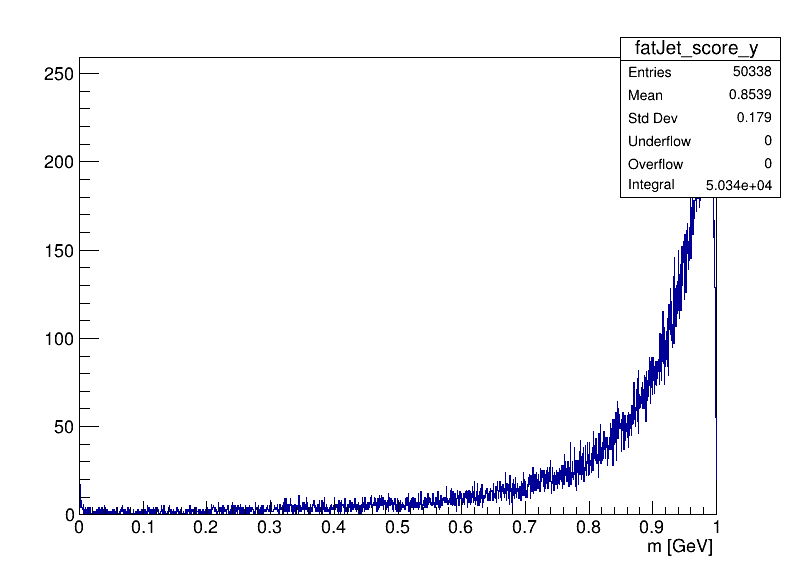

In [3]:
h2.Draw("hist")
c.Draw()